In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.ticker import FuncFormatter
import glob
import os
from datetime import datetime
import seaborn as sns
import re

In [22]:
def data_load(path):
    """
    Load data file.
    """
    df = pd.read_excel(path)
    # remove the last column
    df = df.iloc[:, :-1]
    return df

def get_retired_vehicle(df):
    """
    Get the retired data.
    """
    df = df[df['Pri. Stat.'] == 'Retired']
    return df


def activity_make_model_match(df):
    activity_make_model_df = pd.DataFrame(columns=['Make', 'Model', 'Activity Type Description'])
    for vehicle_type in df['Activity Type Description'].unique():
        vehicle_df = df[df['Activity Type Description'] == vehicle_type]
        make_model = vehicle_df[['Make', 'Model']].drop_duplicates()
        make_model['Activity Type Description'] = vehicle_type
        activity_make_model_df = pd.concat([activity_make_model_df, make_model], ignore_index=True)

    # remove null values
    activity_make_model_df = activity_make_model_df.dropna()
    # sort the dataframe by 'Make' and 'Model'
    activity_make_model_df = activity_make_model_df.sort_values(by=['Make', 'Model'])

    return activity_make_model_df

In [4]:
data_dir = '../../data/Aramco Leased Vehicles - from 2012 up-to-date.xlsx'
fleet_df = data_load(data_dir)
fleet_df.head()

,Pri. Stat.,IMEI Unit,Vehicle Door No,Make,Model,Model Year,Activity Type,Activity Type Description,Actual Retired Date,Fuel Type,service_year
0,Retired,NaN,RT9971,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,03/31/2013,Gasoline,5.0
1,Retired,NaN,RT9972,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,03/31/2013,Gasoline,5.0
2,Retired,NaN,RT9973,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,03/31/2013,Gasoline,5.0
3,Retired,NaN,RT9974,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,03/31/2013,Gasoline,5.0
4,Retired,NaN,RT9975,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,03/31/2013,Gasoline,5.0


In [ ]:
print(fleet_df.shape, fleet_df['Activity Type Description'].nunique())

(25275, 11) 93


In [6]:
retired_vehicle_df = get_retired_vehicle(fleet_df)
print(retired_vehicle_df.shape)
num_total_vehicle_type = fleet_df['Activity Type Description'].nunique()
num_retired_vehicle_type = retired_vehicle_df['Activity Type Description'].nunique()
print(num_retired_vehicle_type, num_total_vehicle_type)
# Get the vehicle types not in retired vehicles
types_not_in_retired = fleet_df[~fleet_df['Activity Type Description'].isin(retired_vehicle_df['Activity Type Description'])]['Activity Type Description'].unique()
print(types_not_in_retired) # ["D Van 12' Hyd. Tailg", 'Re-lamper Truck, 4x', 'Crane Truck 4X2, Die','Comm Emerg. Equip V']

(13133, 11)
89 93
["D Van 12' Hyd. Tailg" 'Re-lamper Truck, 4x' 'Crane Truck 4X2, Die'
 'Comm Emerg. Equip V']


In [7]:
activity_make_model_df = activity_make_model_match(retired_vehicle_df)
activity_make_model_df.head()


,Make,Model,Activity Type Description
142,BMW,740Li,Sedan Executive (3)
143,BMW,750Li,Sedan Executive (3)
2,Cadillac,CT6,Sedan Executive (2)
162,Cadillac,Escalade,Executive Carryall
25,Chevy,Caprice,Sedan Full-Size


In [ ]:
# # save the resulting dataframe to a new excel file
# output_path = '../../results/activity_make_model.xlsx'
# activity_make_model_df.to_excel(output_path, index=False)

In [28]:
# There are only 80 types here rather than 89 because we dropped the null makes and models
activity_make_model_df['Activity Type Description'].nunique()
activity_make_model_df.head()

,Make,Model,Activity Type Description
142,BMW,740Li,Sedan Executive (3)
143,BMW,750Li,Sedan Executive (3)
2,Cadillac,CT6,Sedan Executive (2)
162,Cadillac,Escalade,Executive Carryall
25,Chevy,Caprice,Sedan Full-Size


In [36]:
# Classify vehicles based on make, model, and activity type, join the two dataframes: vehicle_type_df and retired_vehicle_df
# use inner_join here
def classify_vehicle_type(vehicle_type_df, retired_vehicle_df):
    df = vehicle_type_df.iloc[:, :-2]
    df = df.drop(columns=['Vehicle Type', 'Renamed_type'], axis=1)
    # join the two dataframes
    df1 = pd.merge(retired_vehicle_df, df, on=['Make', 'Model', 'Activity Type Description'], how='inner')

    return df1


# The number of unique vehicle types here is 84 which is more than the number of unique vehicle types in the activity_make_model_df because we add those 4 which are not included in the retired vehicles
data_path = '../../results/activity_make_model.xlsx'
vehicle_type_df = pd.read_excel(data_path)
merge_df = classify_vehicle_type(vehicle_type_df, retired_vehicle_df)
print(merge_df['Activity Type Description'].nunique())
vehicle_type_df.head()

80


,Make,Model,Activity Type Description,Vehicle Type,Renamed_type,General Type,Suggested_Classification,note,Unnamed: 8
0,BMW,740Li,Sedan Executive (3),Sedan Executive (3),full-size sedan,light-duty passenger vehicle,sedan,NaN,NaN
1,BMW,750Li,Sedan Executive (3),Sedan Executive (3),full-size sedan,light-duty passenger vehicle,sedan,NaN,NaN
2,Cadillac,CT6,Sedan Executive (2),Sedan Executive (2),full-size sedan,light-duty passenger vehicle,sedan,NaN,NaN
3,Cadillac,Escalade,Executive Carryall,Executive Carryall,full-size SUV,light-duty passenger vehicle,suv,NaN,NaN
4,Chevy,Caprice,Sedan Full-Size,Sedan Full-Size,full-size sedan,light-duty passenger vehicle,sedan,NaN,NaN


In [220]:
# merge activity_make_model matched data with the raw fleet data to check how many vehicles are in each type
raw_fleet_merge_activity_make_model = classify_vehicle_type(vehicle_type_df, fleet_df)
# check the number of unique vehicle types
hdt = raw_fleet_merge_activity_make_model[raw_fleet_merge_activity_make_model['Suggested_Classification']=='heavy-duty truck'].shape[0]
mdt = raw_fleet_merge_activity_make_model[raw_fleet_merge_activity_make_model['Suggested_Classification']=='medium-duty truck'].shape[0]
ldt = raw_fleet_merge_activity_make_model[raw_fleet_merge_activity_make_model['Suggested_Classification']=='light-duty truck'].shape[0]
bus = raw_fleet_merge_activity_make_model[raw_fleet_merge_activity_make_model['Suggested_Classification']=='bus'].shape[0]
sedan = raw_fleet_merge_activity_make_model[raw_fleet_merge_activity_make_model['Suggested_Classification']=='sedan'].shape[0]
suv = raw_fleet_merge_activity_make_model[raw_fleet_merge_activity_make_model['Suggested_Classification']=='suv'].shape[0]
van = raw_fleet_merge_activity_make_model[raw_fleet_merge_activity_make_model['Suggested_Classification']=='van'].shape[0]
total = hdt + mdt + ldt + bus + sedan + suv + van
print(hdt, mdt, ldt, bus, sedan, suv, van, total, raw_fleet_merge_activity_make_model.shape[0])

13 145 6308 17 7087 6025 82 19677 19677


In [37]:
print(retired_vehicle_df.shape, merge_df.shape)
merge_df.head()
merge_df.to_csv('../../results/merged_vehicle_type.csv', index=False)

(13133, 11) (13079, 13)


In [38]:
# Calculate survival rate by vehicle type
def calculate_survival_pattern(df):
    vehicle_types = df['Suggested_Classification'].unique()
    survival_rate = {}

    for veh_type in vehicle_types:
        num_vehicles = len(df[df['Suggested_Classification'] == veh_type])
        survival_rate[veh_type] = []
    
        num_retired = 0
        vehicle_age = range(int(df.loc[df['Suggested_Classification'] == veh_type, 'service_year'].max()) + 1)
        for age in vehicle_age:
            num_retired += len(df[(df['Suggested_Classification'] == veh_type) & (df['service_year'] == age)])
            try:
                survival_rate[veh_type].append((num_vehicles - num_retired)/num_vehicles)
            except ZeroDivisionError:
                survival_rate[veh_type].append(0) 
                print(f"❌ Failed to fetch website: {veh_type} at age {age}")

    survival_rate_df = pd.DataFrame.from_dict(survival_rate, orient='index').fillna(0)
    survival_rate_df.head()

    return survival_rate_df


survival_df = calculate_survival_pattern(merge_df)

In [39]:
survival_df.head()
# survival_df.to_csv('../../results/survival_rate1.csv', index=False)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
suv,0.999715,0.998006,0.988034,0.962108,0.888034,0.736467,0.612821,0.522792,0.338746,0.081481,0.049573,0.003989,0.00057,0.000285,0.000285,0.000285,0.0
light-duty truck,1.000000,0.997257,0.991183,0.974726,0.923589,0.794083,0.570337,0.517241,0.374804,0.323472,0.143613,0.009013,0.00000,0.000000,0.000000,0.000000,0.0
heavy-duty truck,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,0.500000,0.166667,0.166667,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
sedan,0.997900,0.994867,0.983201,0.952170,0.788847,0.639524,0.476668,0.244750,0.112692,0.000933,0.000467,0.000233,0.00000,0.000000,0.000000,0.000000,0.0
medium-duty truck,1.000000,1.000000,1.000000,1.000000,1.000000,0.946237,0.838710,0.763441,0.698925,0.548387,0.129032,0.021505,0.00000,0.000000,0.000000,0.000000,0.0


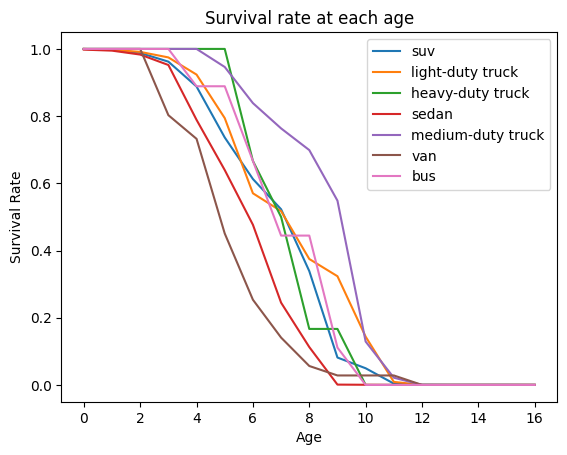

In [40]:
# Visualize the survival rate
for index, row in survival_df.iterrows():
    plt.plot(row, label=index)

plt.xlabel('Age')
plt.ylabel('Survival Rate')
plt.title('Survival rate at each age')
plt.legend()
plt.show()

In [41]:
hdt = merge_df[merge_df['Suggested_Classification']=='heavy-duty truck'].shape[0]
mdt = merge_df[merge_df['Suggested_Classification']=='medium-duty truck'].shape[0]
ldt = merge_df[merge_df['Suggested_Classification']=='light-duty truck'].shape[0]
bus = merge_df[merge_df['Suggested_Classification']=='bus'].shape[0]
sedan = merge_df[merge_df['Suggested_Classification']=='sedan'].shape[0]
suv = merge_df[merge_df['Suggested_Classification']=='suv'].shape[0]
van = merge_df[merge_df['Suggested_Classification']=='van'].shape[0]
print(hdt, mdt, ldt, bus, sedan, suv, van)

6 93 5104 9 4286 3510 71


In [212]:
# calculate annual VKT distribution for each vehicle class
def calculate_annual_vkt_distribution(df, year):
    df = df[df['trip_start_year']==year]
    print(df['Suggested_Classification'].unique())
    # calculate the annual VKT for each vehicle class
    vkt_distribution = df.groupby(['Suggested_Classification', 'Vehicle Door No'])['distance'].sum().reset_index()

    return vkt_distribution
    
    
def vkt_dist_visualization(df, year):

    def sci_formatter(x, pos):
        return f"$10^{int(x)}$" if x >= 1 else ""
    
    vehicle_class = df['Suggested_Classification'].unique()
    class_list = []
    fig, ax = plt.subplots()
    for vehicle_cls in vehicle_class:
        vehicle_type = df[df['Suggested_Classification']==vehicle_cls]['distance']
        sns.histplot(np.log10(vehicle_type.values), stat='percent', kde=True, ax=ax)
        class_list.append(vehicle_cls)
    ax.xaxis.set_major_formatter(FuncFormatter(sci_formatter))
    plt.xlabel('Annual VKT (km)')
    plt.ylabel('Percent')
    plt.title(f'Annual VKT distribution {year}')
    plt.legend(class_list)



In [109]:
cleaned_melt_df = pd.read_csv('../../results/three_data_melt.csv')
merged_vkt_df = pd.merge(cleaned_melt_df, vehicle_type_df, on=['Make', 'Model', 'Activity Type Description'], how='inner')

/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_85766/1289176081.py:1: DtypeWarning: Columns (9,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_melt_df = pd.read_csv('../../results/three_data_melt.csv')


['light-duty truck' 'sedan' 'suv' 'medium-duty truck']


/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_85766/2918071062.py:21: RuntimeWarning: divide by zero encountered in log10
  sns.histplot(np.log10(vehicle_type.values), stat='percent', kde=True, ax=ax)
/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_85766/2918071062.py:21: RuntimeWarning: divide by zero encountered in log10
  sns.histplot(np.log10(vehicle_type.values), stat='percent', kde=True, ax=ax)
/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_85766/2918071062.py:21: RuntimeWarning: divide by zero encountered in log10
  sns.histplot(np.log10(vehicle_type.values), stat='percent', kde=True, ax=ax)


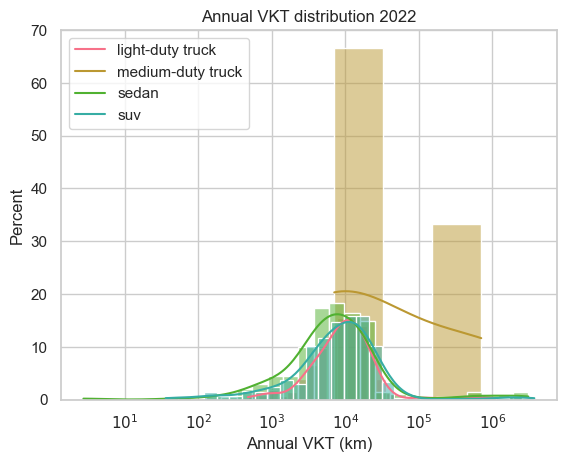

In [ ]:
year = 2022
vkt_distribution = calculate_annual_vkt_distribution(merged_vkt_df, year)
vkt_dist_visualization(vkt_distribution, year)

# Still need to convert the actual recorded vkt of each vehicle (for those cut in or step out during the year) to annual equaivalent vkt

/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_85766/861069409.py:8: RuntimeWarning: divide by zero encountered in log10
  sns.histplot(np.log10(a.values), stat='percent',log_scale=True, kde=True, ax=ax)


<Axes: ylabel='Percent'>

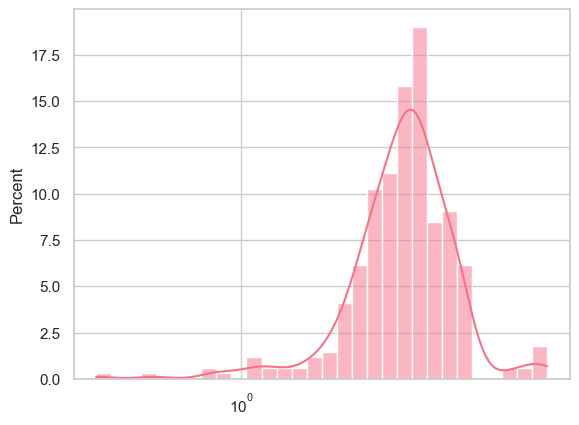

In [ ]:
# when vehicle_start_year equals 2014, trip_start_year is in [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,2023,2024,2025]
# cleaned_melt_df[cleaned_melt_df['trip_start_year'] < cleaned_melt_df['vehicle_start_year']].shape
# print(cleaned_melt_df['trip_start_year'].unique(), cleaned_melt_df['vehicle_start_year'].unique())

In [121]:
merged_vkt_df.columns

Index(['Unnamed: 0', 'Pri. Stat.', 'IMEI Unit', 'Vehicle Door No', 'Make',
       'Model', 'Model Year', 'Activity Type', 'Activity Type Description',
       'Actual Retired Date', 'Fuel Type', 'service_year', 'status',
       'average_speed_with_idle', 'average_speed_without_idle',
       'vehicle_start_year', 'vehicle_stop_year', 'distance', 'idle_time',
       'max_speed', 'moving_time', 'trip_start_year', 'trip_stop_year',
       'Vehicle Type', 'Renamed_type', 'General Type',
       'Suggested_Classification', 'note', 'Unnamed: 8'],
      dtype='object')